In [137]:
#https://www.kaggle.com/code/mhmudalipur/cyclegan

from IPython.display import clear_output as clear
!pip install tensorflow-addons
clear()

In [2]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random

# Data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Model Layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization

# Model Functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal

# Optimizers
from tensorflow.keras.optimizers import Adam

# Loss
from keras.losses import BinaryCrossentropy

# Model Viz
from tensorflow.keras.utils import plot_model

In [3]:
def show_image(image, title=None):
    '''
    The function takes in an image and plots it using Matplotlib.
    '''
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [4]:
root_horse_path = '../input/horse2zebra-dataset/trainA'
root_zebra_path = '../input/horse2zebra-dataset/trainB'
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

In [5]:
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [00:12, 80.16it/s]


In [6]:
dataset = [horse_images, zebra_images]

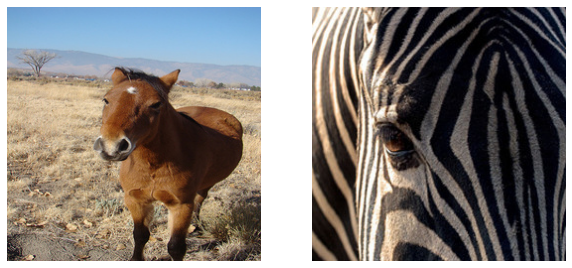

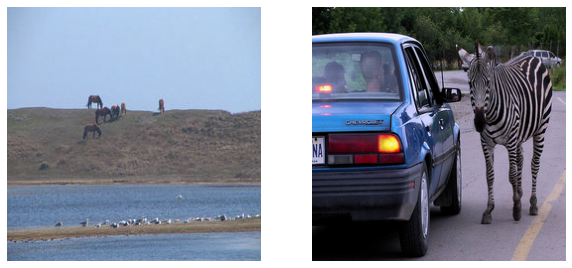

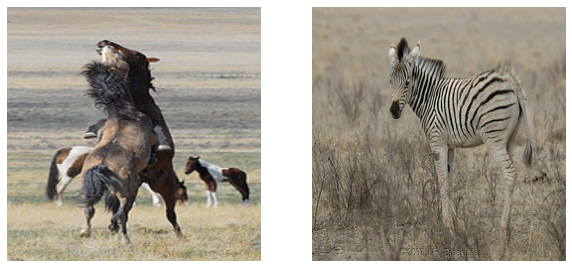

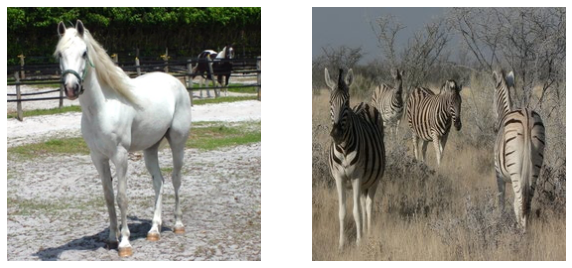

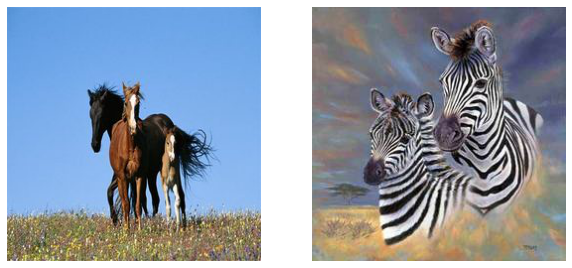

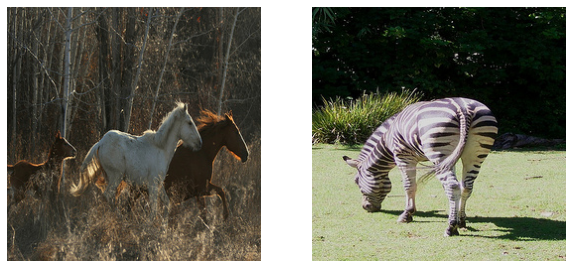

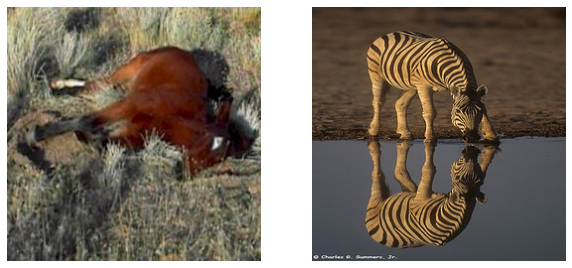

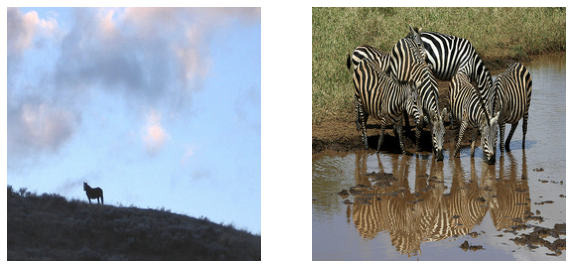

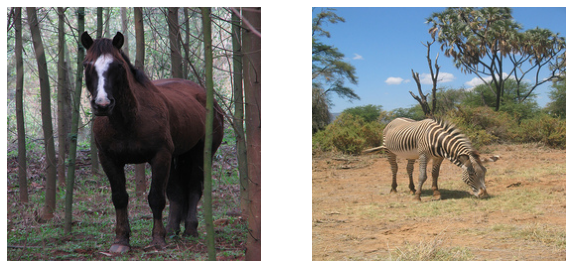

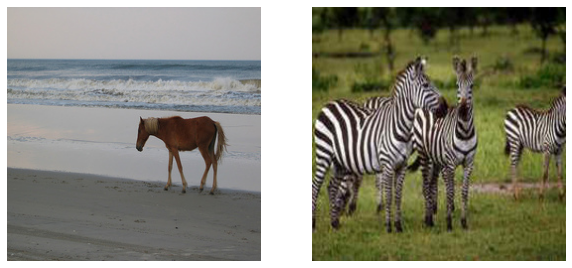

In [7]:
for i in range(10):
    id = np.random.randint(len(horse_images))
    horse, zebra = horse_images[id], zebra_images[id]
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    show_image(horse)
    
    plt.subplot(1,2,2)
    show_image(zebra)
    plt.show()

In [8]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [51]:
def ResidualBlock(filters, layer):
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = concatenate([x, layer])
    return x
    

In [52]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)    
    x = LeakyReLU()(x)
    return x

In [80]:
def upsample(filters, layer, size=3, strides=2):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal')(layer)
    x = InstanceNormalization(axis=-1)(x) 
    x = ReLU()(x)
    return x 

    

In [81]:
def Generator(n_resnet=9):
    inp_image =Input(shape=(SIZE, SIZE, 3))
    x = downsample(64, inp_image, size=7, strides=1)
    x = downsample(128, x)
    x = downsample(256, x)
    
    
    for i in range(n_resnet):
        x = ResidualBlock(256, x)
    
    x = upsample(128, x)
    x = upsample(64, x)
    x = downsample(3, x, size=7, strides=1, activation='tanh')
    
    model = Model(inputs=inp_image, outputs=x)
    return model
    
    
    

In [104]:
def Discriminator():
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3))
    x = downsample(64, src_img, size=4, strides=2, norm=False)
    x = downsample(128, x, size = 4)
    x = downsample(256, x, size = 4)
    x = downsample(512, x, size = 4)
    x = downsample(512, x, size = 4)
    out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer= init, use_bias=False)(x)
    
    
    model = Model(inputs=src_img, outputs= out)
    model.compile(loss='mse', optimizer=Adam(learning_rate=2e-4))
    
    
    return model
    

In [117]:
def CombineModel(g_model1,g_model2, d_model ): # (XY, YX, D) #(YX, XY, D)
    g_model1.trainable = True
    d_model.trainable = False
    g_model2.trainable = False
    
    
    
    #Adversarial loss
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    
    #Identity loss
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)
    
    #Forward Cycle loss
    output_f = g_model2(gen_1_out)
    
    #Backward Cycle loss
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
    
    model = Model(inputs=[input_gen, input_id], 
                 outputs=[dis_out, output_id,output_f, output_b ])
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=Adam(learning_rate=2e-4))
    
    return model

In [126]:
def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y
    

In [127]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

In [135]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(horse_images))
        horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = g_BA.predict(tf.expand_dims(zebra, axis=0))[0], g_AB.predict(tf.expand_dims(horse, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1, 4, 2)
        show_image(zebra_pred, title='Generated Horse')
        
        plt.subplot(1, 4, 3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1, 4, 4)
        show_image(horse_pred, title='Generated Zebra')
        
        
        plt.show()

In [129]:
def train(d_model_A, d_model_B, gen_AB, gen_BA, c_AB, c_BA, epochs=10, chunk=5):
    n_epochs, n_batch = epochs, 1
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    
    batch_per_epoch = int(len(trainA)/n_batch)
    n_steps = batch_per_epoch
    
    for j in tqdm(range(1, epochs+1)):
        for i in range(n_steps):
            
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)
            
            X_fakeA, y_fakeA = generate_fake_samples(gen_BA, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(gen_AB, X_realA)
            
            
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            gen_loss2, _, _, _ = c_BA.train_on_batch([X_realB, X_realA], [y_realB, X_realA, X_realB, X_realA])
            
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            gen_loss1, _, _, _ = c_AB.train_on_batch([X_realA, X_realB], [y_realA, X_realB, X_realA, X_realB])

            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            
        if(j%chunck)==0:
            show_preds(gen_AB, gen_BA, n_images=1)
            gen_AB.save('GeneratorHtoZ.h5')
            gen_BA.save('GeneratorZtoH.h5')
            
                 

In [130]:
g_AB = Generator()
g_BA = Generator()

d_A = Discriminator()
d_B = Discriminator()


c_AB = CombineModel(g_AB, g_BA, d_B)
c_BA = CombineModel(g_BA, g_AB, d_A)


In [132]:
#train(d_A, d_B, g_AB, g_BA, c_AB, c_BA, epochs=1, chunk=5)

In [133]:
HtoZ_gen = load_model('../input/imagetoimage-translation-cyclegan/GeneratorHtoZ.h5')
ZtoH_gen = load_model('../input/imagetoimage-translation-cyclegan/GeneratorZtoH.h5')

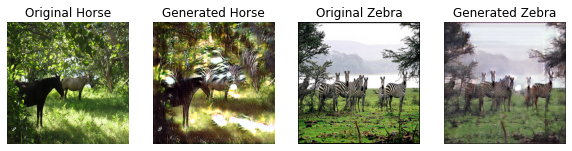

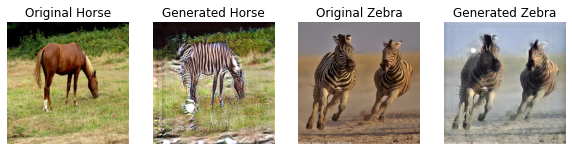

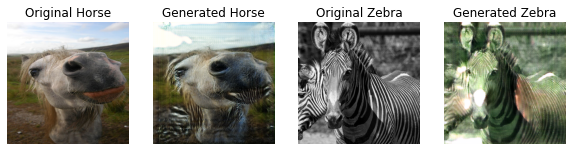

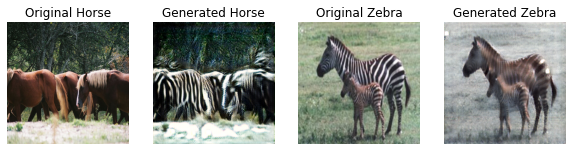

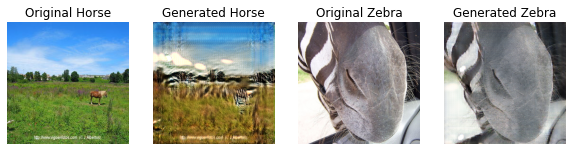

In [136]:
show_preds(HtoZ_gen, ZtoH_gen, n_images=5)